# Практическое задание к уроку 6. Сегментация

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите  результата. Что помогло повысить точность?
 
3. *Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview4. 
4. *Сделайте свою реализацию U-Net на TensorFlow

In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-m1lahb4v
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-m1lahb4v
  Resolved https://github.com/tensorflow/examples.git to commit 8c01781c51a56ee2e78fbbdc696581c6942f92c3
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-8c01781c51a56ee2e78fbbdc696581c6942f92c3_-py3-none-any.whl size=269029 sha256=92d846d8b9168dd73aaf630ebbfc0428d85301fc92c8067431caee888a739752
  Stored in directory: /tmp/pip-ephem-wheel-cache-nl43vu_j/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Di

In [3]:
!pip install -U tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 KB 8.3 MB/s eta 0:00:00


In [4]:
!pip install tensorflow -latest


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -l


In [5]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 4.3 MB/s eta 0:00:00


In [6]:
!pip install tensorflow_datasets

In [7]:
!pip install opencv-python

In [8]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

import tensorflow.compat.v2 as tf

from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import EarlyStopping 

from PIL import Image

import cv2

# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [9]:
try:
  %tensorflow_version only exists in Colab.
  #%tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 2.x
Available versions:
 * 1.x
 * 2.x


#### Загрузка датасета caltech_birds2010

In [10]:
ds_names = ( 'caltech_birds2010:0.*.*',)
dataset_all, info = tfds.load(ds_names[0], split = ['train[:10%]','test[-10%:]'], with_info=True)

Dataset caltech_birds2010 downloaded and prepared to ~/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.


In [11]:
info

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='~/tensorflow_datasets/caltech_birds2010/0.1.1',
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask':

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}

In [12]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
#   input_mask -= 1
  return input_image, input_mask

In [13]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [14]:
@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Датасет уже содержит необходимые тестовый и тренировочный сплиты, поэтому давайте использовать их.

In [15]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // 10 // BATCH_SIZE

In [16]:
# генераторы
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

In [17]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Давайте посмотрим на пример изображения из датасета и соотвествующую ему маску из датасета.

In [18]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

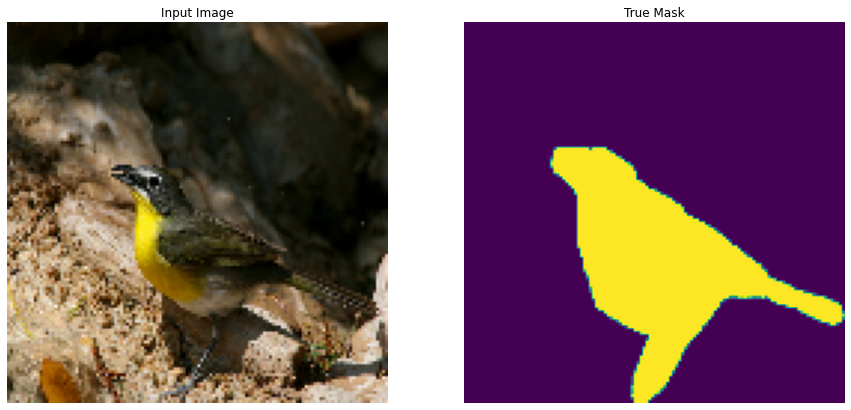

In [19]:
for image, mask in test_dataset.take(1):
  sample_image, sample_mask = image, mask
display([sample_image[0,:,:,:], sample_mask[0,:,:,:]])

In [20]:
sample_mask.numpy().min(),sample_mask.numpy().max()

(0.0, 1.0)

In [21]:
sample_mask.dtype

tf.float32

#### Определение модели

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2. Декодером будет апсемпл блок уже имплементированный в TensorFlow examples Pix2pix tutorial.
Причина по который будет испольваться три канала заключается в том что у нас 3 возможных лейбла на каждый пиксель. Можно это воспринимать как классиификацию где кажедый пиксель будет принадлежать одному из трех классов.

In [22]:
OUTPUT_CHANNELS = 3

Как упоминалось ранее энкодером будет предтренированный MobileNetV2, который подготовлен и готов к использованию - [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). Энкодер состоит из определенных аутпутов из средних слоев модели. Обратите внимание энкодр не будет участвовать в процессе тренировкие модели.

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


Декодер/апсемплер это просто серия апсемпл блоков имплементированнхы в TensorFlow examples.

In [24]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [25]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#### Тренировка модели

Now, all that is left to do is to compile and train the model. The loss being used here is losses.SparseCategoricalCrossentropy(from_logits=True). The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.SparseCategoricalCrossentropy(from_logits=True) is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

Теперь, все что осталось это скомпилировать модель и начать процесс ее тренировки. Loss-функция, которую будем использовать - losses.SparseCategoricalCrossentropy(from_logits=True). Причина использования данной loss-функции заключается в том, что нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 каннала каждый из которых пытается предсказать класс losses.SparseCategoricalCrossentropy(from_logits=True) обычно также рекомендуется. На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением. Это то, что делает функция create_mask.

In [26]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Посмотрим на получившуюся архитектуру модели.

In [27]:
!pip install pydot

In [28]:
!pip install graphviz

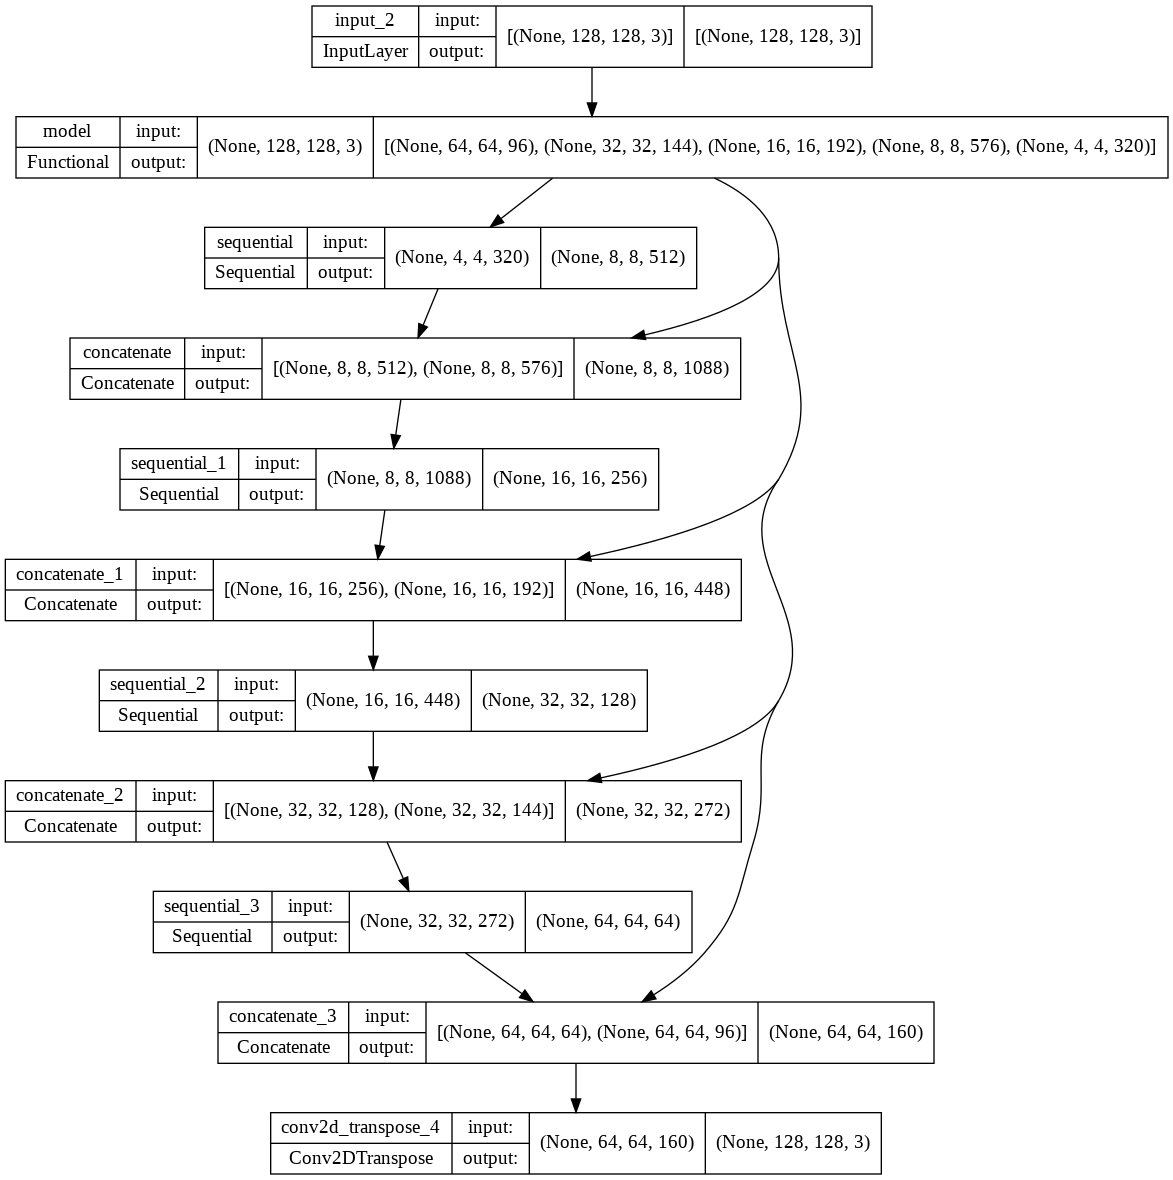

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [30]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [31]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(1)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image[0,:,:,:], sample_mask[0,:,:,:],
             create_mask(model.predict(sample_image[:,:,:]))])

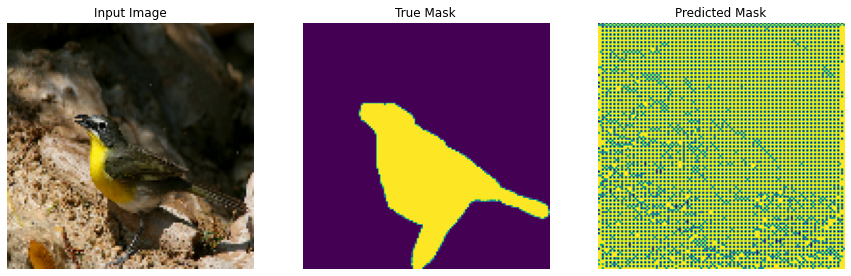

In [32]:
show_predictions()

Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

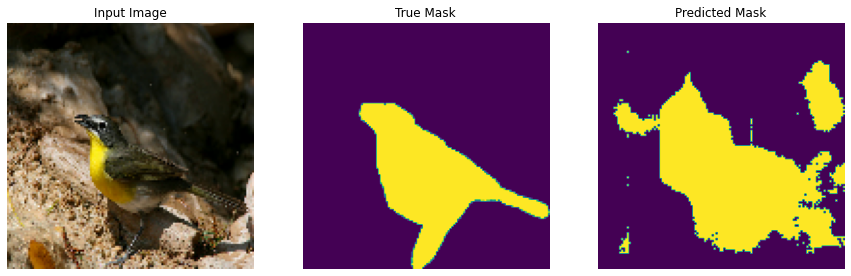


Sample Prediction after epoch 5

18/18 [==============================] - 29s 2s/step - loss: 0.1239 - accuracy: 0.9492 - val_loss: 0.5452 - val_accuracy: 0.8116


In [34]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

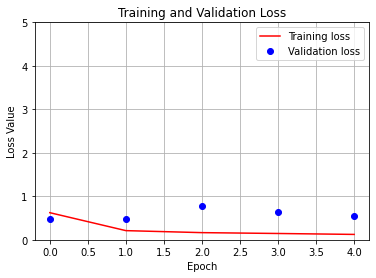

In [35]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 5])
plt.grid('on')
plt.legend()
plt.show()

#### Make predictions

Давайте сделаем несколько предсказаний. Для экономии времени использовалось небольшое количество эпох, но вы можете его увеличить для того чтобы модель давала более точные результаты.

1


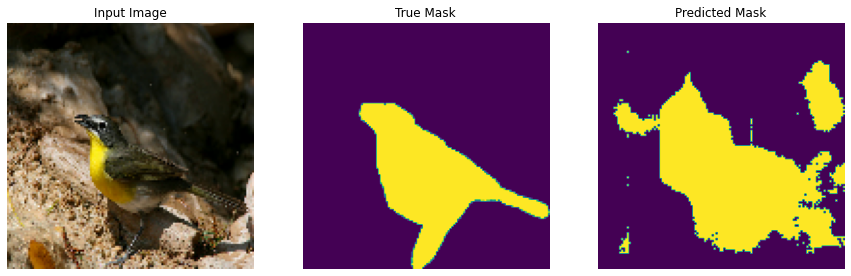

1


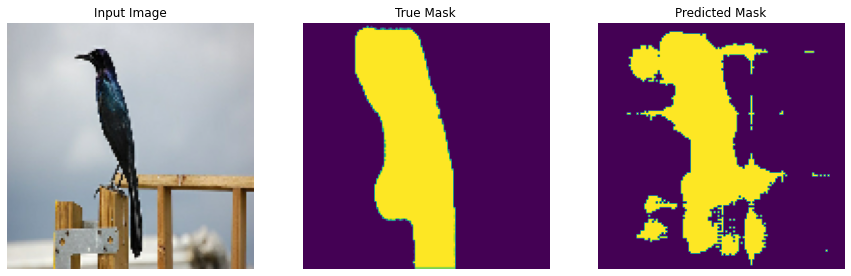

1


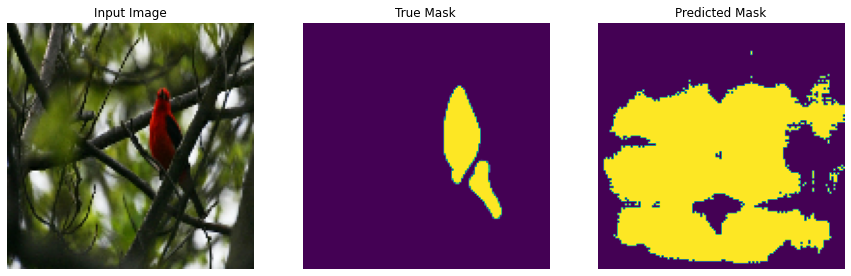

In [36]:
show_predictions(test_dataset, 3)